# Data Science in Inudstry Final Project - Saloni Tripathi

## Authentication

Go to 
https://cloud.google.com/docs/authentication/getting-started to set up an account and an API key. Follow the instructions and then replace the link below with the JSON file that gets downloaded. 

In [299]:
import pandas as pd
import os

pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/eagarwal/Downloads/snt-a6bc4b1cdbfe.json"

## Collect Data

In [549]:
from google.cloud import bigquery
client = bigquery.Client()

### Gather all data into pandas dataframes
### collecting data and features from: trips, weather, vehicle collisions

query_trips = (
    """
        CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
          ACOS(-1.0) * x / 180.0
        );
        CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
          111.045 * 180.0 * x / ACOS(-1.0)
        );
        CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                                       lat2 FLOAT64, long2 FLOAT64) AS (
          RADIANS_TO_KM(
            ACOS(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
                 COS(RADIANS(long1) - RADIANS(long2)) +
                 SIN(RADIANS(lat1)) * SIN(RADIANS(lat2)) - .0001)
            )
        );
        
        SELECT 
            pickup_datetime,
            dropoff_datetime,
            pickup_longitude,
            pickup_latitude,
            dropoff_longitude,
            dropoff_latitude,
            trip_distance,
            fare_amount,
            HAVERSINE(dropoff_latitude,dropoff_longitude, pickup_latitude, pickup_longitude) AS haversine_distance,
            TIMESTAMP_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time,
            EXTRACT (DATE FROM pickup_datetime) as date_of_year,
            EXTRACT (MONTH FROM pickup_datetime) as month
        FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
        WHERE trip_distance != 0.0 AND pickup_longitude < 100 AND pickup_latitude > 20
        ORDER BY RAND()
        LIMIT 100000
    """
)
trips_raw_data2 = pd.io.gbq.read_gbq(query_trips,dialect='standard')

query_weather = """
    SELECT 
        temp,dewp,visib,wdsp,gust,prcp,sndp,
        CONCAT(year,'-',mo,'-',da) as weather_date_of_year
    FROM `bigquery-public-data.noaa_gsod.gsod2016`
    WHERE year = '2016' AND stn='725053'
"""
weather_raw_data2 = pd.io.gbq.read_gbq(query_weather,dialect='standard')

query_collisions = """
    SELECT 
        timestamp,
        EXTRACT(DATE from timestamp) as collision_date,
        borough,
        contributing_factor_vehicle_1,
        latitude as collision_latitude,
        longitude as collision_longitude,
        number_of_persons_injured,
        vehicle_type_code1
    FROM `bigquery-public-data.new_york.nypd_mv_collisions`
    WHERE EXTRACT(YEAR from timestamp) = 2016
    LIMIT 100000
"""
collisions_raw_data2 = pd.io.gbq.read_gbq(query_collisions,dialect='standard')

In [550]:
trips_raw_data = trips_raw_data2.copy()
weather_raw_data = weather_raw_data2.copy()
collisions_raw_data = collisions_raw_data2.copy()

## Process Data and Compute Extra Features

I compute several new features that will hopefully prove to have predictive power in the models that I train later on. These features fall under two categories: distance and traffic

I compute three measures for distance and use these all as features: euclidean, manhattan, and haversine distance. The computation of these is fairly straightfoward.

While not a perfect measure, I use the number of trips in the previous hour as a metric for how much traffic could impact the travel time. I do this by extracting the date and hour from the trips data and perform a group by operation on both those fields, and in the process, counting the number of rows in each of these 'buckets'. This provides a measure I call 'total_traffic_rides'. I also calculate the average speeds of the rides in the previous hour using each of the three distance divided by the time taken for that ride (these rides are an aggregate of all rides in the previous hour, therefore, using travel time here is not specific to the input being predicted, and is not providing an unfair signal that isn't present at prediction time).

In [554]:
import math
import numpy as np

### STORE sql queried data into dataframes for computation and FORMAT date columns
trips_data = trips_raw_data.copy()
weather_data = weather_raw_data.copy()
collisions_data = collisions_raw_data.copy()

trips_data['date_of_year'] = pd.to_datetime(trips_data['date_of_year'])
weather_data['weather_date_of_year'] = pd.to_datetime(weather_data['weather_date_of_year'])
collisions_data['collision_date'] = pd.to_datetime(collisions_data['collision_date'])

### JOIN data
twc_data = pd.merge(trips_data, weather_data, left_on='date_of_year', right_on='weather_date_of_year')

### REMOVE bad rows
twc_data = twc_data[~((twc_data['pickup_latitude'] == twc_data['dropoff_latitude']) & (twc_data['pickup_longitude'] == twc_data['dropoff_longitude']))]

### COMPUTE extra features
twc_data['max_trip_latitude'] = twc_data[['pickup_latitude','dropoff_latitude']].max(axis=1)
twc_data['min_trip_latitude'] = twc_data[['pickup_latitude','dropoff_latitude']].min(axis=1)

twc_data['max_trip_longitude'] = twc_data[['pickup_longitude','dropoff_longitude']].max(axis=1)
twc_data['min_trip_longitude'] = twc_data[['pickup_longitude','dropoff_longitude']].min(axis=1)

twc_data['trip_latitude_difference'] = twc_data['max_trip_latitude'] - twc_data['min_trip_latitude']
twc_data['trip_longitude_difference'] = twc_data['max_trip_longitude'] - twc_data['min_trip_longitude']

twc_data['trip_euclidean_distance'] = np.sqrt(twc_data['trip_latitude_difference'].pow(2) + twc_data['trip_longitude_difference'].pow(2))
twc_data['trip_manhattan_distance'] = twc_data['trip_latitude_difference'] + twc_data['trip_longitude_difference']

### TRAFFIC FEATURES
twc_data['pickup_hour'] = twc_data['pickup_datetime'].dt.hour
traffic_data = twc_data[['date_of_year', 'pickup_datetime', 'pickup_hour', 'travel_time', 'trip_euclidean_distance', 'trip_manhattan_distance', 'haversine_distance']]
traffic_data = traffic_data[traffic_data['trip_euclidean_distance'] > 0]
traffic_data = traffic_data[traffic_data['trip_manhattan_distance'] > 0]
traffic_data = traffic_data[traffic_data['haversine_distance'] > 0]
traffic_data['euclidean_speed'] = traffic_data['trip_euclidean_distance'] * 1000 / traffic_data['travel_time']
traffic_data['manhattan_speed'] = traffic_data['trip_manhattan_distance'] * 1000 / traffic_data['travel_time']
traffic_data['haversine_speed'] = traffic_data['haversine_distance'] / traffic_data['travel_time']
traffic_data['traffic_hour'] = traffic_data['pickup_hour'] + 1

traffic_data = traffic_data.groupby(['traffic_hour'], as_index=False).agg({
    'pickup_datetime': 'count',
    'euclidean_speed': 'mean',
    'manhattan_speed': 'mean',
    'haversine_speed': 'mean'
})

traffic_data.columns = ['traffic_hour', 'total_traffic_rides', 'euclidean_speed', 'manhattan_speed', 'haversine_speed']

### JOIN traffic data 
twc_data = pd.merge(twc_data, traffic_data, how='left', left_on=['pickup_hour'], right_on=['traffic_hour'])

# COLLISION features
collisions_counts = collisions_data.groupby('collision_date', as_index=False)['collision_latitude'].count()
collisions_counts.columns = ['collision_date', 'collisions_daily_count']
twc_data = pd.merge(twc_data, collisions_counts, left_on='date_of_year', right_on='collision_date')
twc_data.head()
print(twc_data.shape)


(99673, 36)


In [555]:
%matplotlib inline

## Filter and Clean Feature Data Set

In [556]:
import matplotlib.pyplot as plt

print(twc_data.shape)
twc_data = twc_data.dropna(subset=['manhattan_speed', 'haversine_distance', 'haversine_speed'])

twc_data = twc_data[twc_data['trip_euclidean_distance'] < twc_data['trip_euclidean_distance'].quantile(.995)]
twc_data = twc_data[twc_data['trip_euclidean_distance'] > twc_data['trip_euclidean_distance'].quantile(.005)]

twc_data = twc_data[twc_data['haversine_distance'] < twc_data['haversine_distance'].quantile(.995)]

twc_data = twc_data[twc_data['pickup_latitude'] < twc_data['pickup_latitude'].quantile(.99)]
twc_data = twc_data[twc_data['pickup_latitude'] > twc_data['pickup_latitude'].quantile(.01)]

twc_data = twc_data[twc_data['travel_time'] < twc_data['travel_time'].quantile(.99)]
twc_data = twc_data[twc_data['travel_time'] > twc_data['travel_time'].quantile(.01)]

twc_data = twc_data[twc_data['manhattan_speed'] < twc_data['manhattan_speed'].quantile(.99)]

print(twc_data.shape)

(99673, 36)
(88417, 36)


## Analyze Feature Relevance

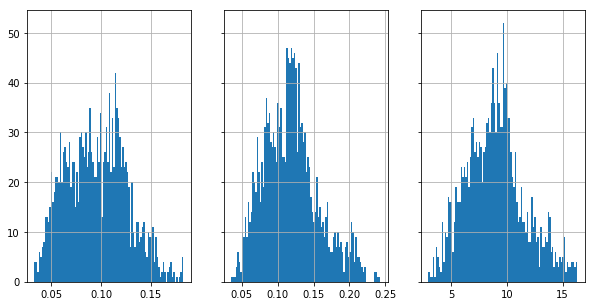

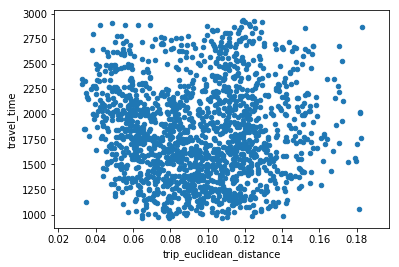

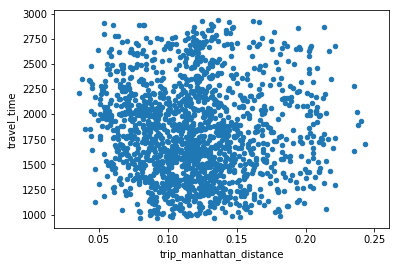

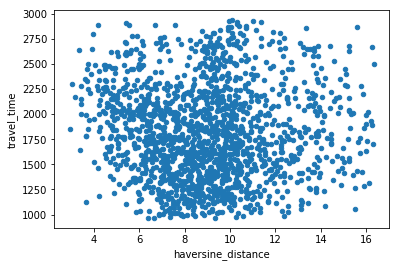

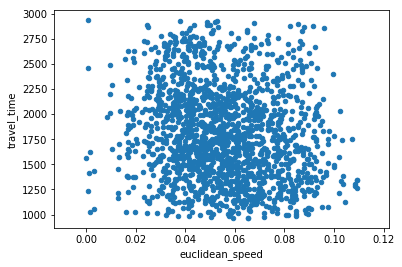

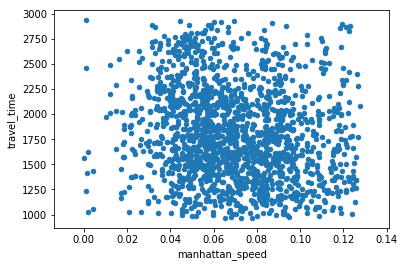

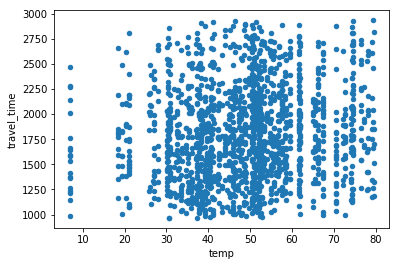

In [414]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(10, 5))

twc_data['trip_euclidean_distance'].hist(bins=100, ax=ax[0])
twc_data['trip_manhattan_distance'].hist(bins=100, ax=ax[1])
twc_data['haversine_distance'].hist(bins=100, ax=ax[2])

twc_data.plot(x='trip_euclidean_distance',y='travel_time',kind='scatter')
twc_data.plot(x='trip_manhattan_distance',y='travel_time',kind='scatter')
twc_data.plot(x='haversine_distance',y='travel_time',kind='scatter')

#twc_data['collisions_daily_count'].hist(bins=50)
#twc_data.plot(x='collisions_daily_count',y='travel_time',kind='scatter')
twc_data.plot(x='euclidean_speed',y='travel_time',kind='scatter')
twc_data.plot(x='manhattan_speed',y='travel_time',kind='scatter')
twc_data.plot(x='temp',y='travel_time',kind='scatter')


Here we join with the publicly available weather data. This isn't required, but the goal here is just to show you what's posisble
with big query. Spend some time exploring the public data and coming up with hypotheses!


# Train Models

## Polynomial Regression

Best Polynmial Degree:  2
Training score:  0.6795123281199078 
Test score: 0.6749636089017537
Best Polynmial Degree:  4
Training score:  0.6993785405451003 
Test score: 0.6799549468440729
Best Polynmial Degree:  4
Training score:  0.6957418903310566 
Test score: 0.6788876824760073
Best Polynmial Degree:  2
Training score:  0.6783225030370725 
Test score: 0.6809460926801645
Best Polynmial Degree:  3
Training score:  0.6960558489082114 
Test score: 0.6802735749694829


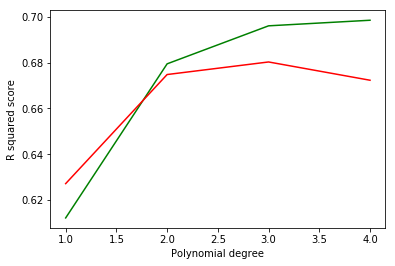

Average RMSE: 332.312
Average Absolute Error: 230.049
Average MAPE: 33.840%


In [567]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    rmse = np.sqrt(np.sum(np.square(errors)) / errors.size)
    avg_error = np.mean(errors)
    mape = np.mean(np.abs((test_labels - predictions) / test_labels)) * 100
    print('Average Absolute Error = {:0.3f}'.format(avg_error))
    print('RMSE = {:0.3f}'.format(rmse))
    print('Mean Absoltue Percentage Error = {:0.3f}%'.format(mape))
    
    return rmse, avg_error, mape

### FEATURE ENGINEERING
y = twc_data['travel_time']
X = twc_data[[
    'temp', 
    'pickup_latitude',
    'pickup_longitude',
    'dropoff_latitude',
    'dropoff_longitude',
    'trip_euclidean_distance', 
    'trip_manhattan_distance', 
    'haversine_distance',
    'haversine_speed', 
    'manhattan_speed', 
    'euclidean_speed', 
    'total_traffic_rides',
    'traffic_hour',
    'month'
]]

### K FOLD CROSS VALIDATION
cv = KFold(n_splits=5, random_state=42, shuffle=False)

######### POLYNOMIAL REGRESSION ##################

rmse = []
avg_error = []
mape = []

for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

    degree = [1, 2, 3, 4]
    train_scores = []
    test_scores = []
    models = []
    for d in degree:
        linear = LinearRegression()
        poly = PolynomialFeatures(d)
        x_train_poly = poly.fit_transform(X_train)
        x_test_poly = poly.fit_transform(X_test)

        linear.fit(x_train_poly, y_train)
        train_score = linear.score(x_train_poly, y_train)
        test_score = linear.score(x_test_poly, y_test)
        train_scores.append(train_score)
        test_scores.append(test_score)
        models.append(linear)

    best_degree = np.argmax(test_scores)
    print("Best Polynmial Degree: ", best_degree+1)
    print("Training score: ", train_scores[best_degree], "\nTest score:", test_scores[best_degree])

    rmse.append(rmse_)
    avg_error.append(avg_error_)
    mape.append(mape_)
    
plt.plot(degree, train_scores, 'g')
plt.plot(degree, test_scores, 'r')
plt.xlabel('Polynomial degree')
plt.ylabel('R squared score')
plt.show()    

avg_rmse = np.mean(rmse)
avg_avg_error = np.mean(avg_error)
avg_mape = np.mean(mape)

print("Average RMSE: {:0.3f}".format(avg_rmse))
print("Average Absolute Error: {:0.3f}".format(avg_avg_error))
print("Average MAPE: {:0.3f}%".format(avg_mape))

poly = PolynomialFeatures(2)
x_test_poly = poly.fit_transform(X_test)
rmse_, avg_error_, mape_ = evaluate(models[best_degree], x_test_poly, y_test.values)

## Regularized Regression

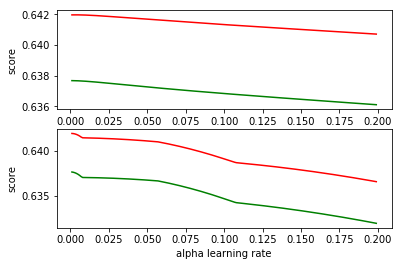

Best Ridge Model
Average Absolute Error = 227.036
RMSE = 314.531
Mean Absoltue Percentage Error = 37.717%

Best Lasso Model
Average Absolute Error = 227.039
RMSE = 314.532
Mean Absoltue Percentage Error = 37.715%


In [543]:
########## RIDGE REGRESSION #################
ridge_test_scores = []
ridge_train_scores = []
alpha_range = np.arange(0.001, .2, 0.001)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge_models = []
for a in alpha_range:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    rr_train_score = ridge.score(X_train,y_train)
    rr_test_score = ridge.score(X_test, y_test)
    ridge_train_scores.append(rr_train_score)
    ridge_test_scores.append(rr_test_score)
    ridge_models.append(ridge)

plt.subplot(2, 1, 1)
plt.plot(alpha_range, ridge_train_scores, 'g')
plt.plot(alpha_range, ridge_test_scores, 'r')
plt.xlabel('alpha learning rate')
plt.ylabel('score')

######## LASSO REGRESSION ###################
lasso_test_scores = []
lasso_train_scores = []
lasso_models = []
for a in alpha_range:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    lasso_train_score = lasso.score(X_train,y_train)
    lasso_test_score = lasso.score(X_test, y_test)
    lasso_train_scores.append(lasso_train_score)
    lasso_test_scores.append(lasso_test_score)
    lasso_models.append(lasso)
    
plt.subplot(2, 1, 2)
plt.plot(alpha_range, lasso_train_scores, 'g')
plt.plot(alpha_range, lasso_test_scores, 'r')
plt.xlabel('alpha learning rate')
plt.ylabel('score')
plt.show()

ridge_i = np.argmax(ridge_test_scores)
lasso_i = np.argmax(lasso_test_scores)
best_ridge_model = ridge_models[ridge_i]
best_lasso_model = lasso_models[lasso_i]

print("Best Ridge Model")
accuracy = evaluate(best_ridge_model, X_test, y_test)
print("\nBest Lasso Model")
accuracy = evaluate(best_lasso_model, X_test, y_test)

## Random Forests

In [581]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

### FEATURE ENGINEERING
y = twc_data['travel_time']
X = twc_data[[
    'pickup_latitude',
    'pickup_longitude',
    'dropoff_latitude',
    'dropoff_longitude',
    'trip_euclidean_distance', 
    'trip_manhattan_distance', 
    'haversine_distance',
    'haversine_speed', 
    'manhattan_speed', 
    'euclidean_speed', 
    'total_traffic_rides',
    'traffic_hour',
    'month'
]]

param_grid = {
    'bootstrap': [True],
    'max_depth': [8, 10, 12, 14, 16],
    'max_features': [4, 6, 8, 10],
    'min_samples_leaf': [5, 7, 9, 11],
    'min_samples_split': [10, 15, 20],
    'n_estimators': [100, 150, 200]
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

rf_clf = RandomForestRegressor(n_estimators=100,
                             random_state=0,max_depth=5)

grid_search = GridSearchCV(estimator = rf_clf, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)

poly = PolynomialFeatures(2)
x_train_poly = poly.fit_transform(X_train)
x_test_poly = poly.fit_transform(X_test)

grid_search.fit(x_train_poly, y_train)
grid_search.best_params_
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, x_test_poly, y_test)

print(best_grid)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 51.2min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 79.8min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 116.6min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 135.4min finished


Average Absolute Error = 200.136
RMSE = 281.994
Mean Absoltue Percentage Error = 31.386%
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=None, oob_score=False, random_state=0,
           verbose=0, warm_start=False)


## Make predictions on final test dataset
Calculate the features for each of the test rows and use model to output predictions

In [590]:
# Taken from https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
from math import radians, cos, sin, asin, sqrt
def haversine(row):
    # convert decimal degrees to radians 
    lon1 = row['pickup_longitude']
    lat1 = row['pickup_latitude']
    lon2 = row['dropoff_longitude']
    lat2 = row['dropoff_latitude']
    
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371.0 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

final_test_dataset = pd.read_csv('APMA4990_final_test_data_filtered.csv')
final_test_dataset['max_trip_latitude'] = final_test_dataset[['pickup_latitude','dropoff_latitude']].max(axis=1)
final_test_dataset['min_trip_latitude'] = final_test_dataset[['pickup_latitude','dropoff_latitude']].min(axis=1)

final_test_dataset['max_trip_longitude'] = final_test_dataset[['pickup_longitude','dropoff_longitude']].max(axis=1)
final_test_dataset['min_trip_longitude'] = final_test_dataset[['pickup_longitude','dropoff_longitude']].min(axis=1)

final_test_dataset['trip_latitude_difference'] = final_test_dataset['max_trip_latitude'] - final_test_dataset['min_trip_latitude']
final_test_dataset['trip_longitude_difference'] = final_test_dataset['max_trip_longitude'] - final_test_dataset['min_trip_longitude']

final_test_dataset['trip_euclidean_distance'] = np.sqrt(final_test_dataset['trip_latitude_difference'].pow(2) + final_test_dataset['trip_longitude_difference'].pow(2))
final_test_dataset['trip_manhattan_distance'] = final_test_dataset['trip_latitude_difference'] + final_test_dataset['trip_longitude_difference']
final_test_dataset['haversine_distance'] = final_test_dataset.apply(lambda row: haversine(row), axis=1)

final_test_dataset['pickup_datetime'] = pd.to_datetime(final_test_dataset['pickup_datetime'])
final_test_dataset['month'] = final_test_dataset['pickup_datetime'].dt.month
final_test_dataset['pickup_hour'] = final_test_dataset['pickup_datetime'].dt.hour
final_test_dataset = pd.merge(final_test_dataset, traffic_data, how='left', left_on=['pickup_hour'], right_on=['traffic_hour'])

X = final_test_dataset[[
    'pickup_latitude',
    'pickup_longitude',
    'dropoff_latitude',
    'dropoff_longitude',
    'trip_euclidean_distance', 
    'trip_manhattan_distance', 
    'haversine_distance',
    'haversine_speed', 
    'manhattan_speed', 
    'euclidean_speed', 
    'total_traffic_rides',
    'traffic_hour',
    'month'
]]

X = X.fillna(0)
X = X.replace([np.inf, -np.inf], 0)

poly = PolynomialFeatures(2)
final_predictions_features = poly.fit_transform(X)

predictions = best_grid.predict(final_predictions_features)

np.savetxt('final_predictions.csv', predictions, delimiter=",")


In [591]:
X.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_euclidean_distance,trip_manhattan_distance,haversine_distance,haversine_speed,manhattan_speed,euclidean_speed,total_traffic_rides,traffic_hour,month
0,40.702740,-74.011650,40.773361,-73.990311,0.073775,0.091961,8.055939,0.198519,0.055802,0.042797,5733.0,21.0,6
1,40.733608,-74.003098,40.836803,-73.941643,0.120108,0.164650,12.587349,0.217021,0.066999,0.051695,2617.0,2.0,11
2,40.730911,-74.001442,40.665699,-73.956909,0.078967,0.109745,8.165491,0.240076,0.341365,0.253893,1360.0,4.0,2
3,40.774078,-73.874550,40.749939,-73.991203,0.119125,0.140793,10.184872,0.201281,0.119480,0.089399,4749.0,9.0,7
4,40.791588,-73.964874,40.792084,-73.968254,0.003416,0.003876,0.289822,0.373311,2.610329,1.923027,5171.0,18.0,1


# Citations

For some features ideas:
http://cs229.stanford.edu/proj2016/report/AntoniadesFadaviFobaAmonJuniorNewYorkCityCabPricing-report.pdf

For working with GridSearchCV: 
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74